# Setup Env

## Install Python Package

In [29]:
!pip install librosa matplotlib tqdm kagglehub


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


## Import Pyhton Package

In [1]:
import pathlib
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.cuda.amp import GradScaler, autocast
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hashlib
import librosa
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Process dataset

## Download Dataset

In [139]:
import kagglehub

# Download latest version
cremad_dataset_path = kagglehub.dataset_download("ejlok1/cremad")

print("Path to cremad dataset files:", cremad_dataset_path)

# Download latest version
ravdess_dataset_path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")
print("Path to ravdess dataset files:", ravdess_dataset_path)

Path to cremad dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1
Path to ravdess dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


## Get label from audio file name

In [140]:
CREMA=cremad_dataset_path + '/AudioWAV/'
crema_dir_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_list = [
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
]
for audio_file in crema_dir_list:
    part = audio_file.split('_')
    key = part[2]
    if key in emotion_dic:
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_list else 'male')
        emotion_list.append(emotion_dic[key])

crema_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

In [141]:
RAVDESS=ravdess_dataset_path + '/audio_speech_actors_01-24/'
ravdess_dir_lis = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

emotion_dic = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}
count=0
for directory in ravdess_dir_lis:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files:
        count+=1
        part = audio_file.split('.')[0]
        key = part.split('-')[2]
        if key in emotion_dic:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion_dic[key])
        # else:
        #     print(part)
            
ravdess_df = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)


In [142]:
print('Creama Dataset Shape is ', crema_df.shape) 
print('Creama Dataset Shape is ', ravdess_df.shape)

Creama Dataset Shape is  (7442, 3)
Creama Dataset Shape is  (1056, 3)


## Analysis dataset

In [ ]:
# 使用方法
from torch.utils.data import Dataset, DataLoader
train_dataset = AudioDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# 檢查數據
max_count = -1
for batch in train_loader:
    mfcc_batch, labels = batch
    # print("MFCC batch shape:", mfcc_batch.shape)
    # print(mfcc_batch[5][1])
    for mfcc in mfcc_batch:
        for f in mfcc:
            new = torch.count_nonzero(f).item()
            max_count=max(max_count, new)
print(max_count)

In [101]:
audio, _ = librosa.load(audio_path)
audio = clip_audio(audio, 2.5)
audio = np.append(audio[0], audio[1:] - pre_emphasis_coeff * audio[:-1])

n_mfcc=20
sr=22050
n_fft=2048
hop_length=512

In [102]:
mfcc = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)


In [103]:
print(mfcc)

[[-1.0583916e+03 -1.0591807e+03 -1.0589695e+03 ... -9.3900897e+02
  -9.4690161e+02 -9.6291724e+02]
 [-1.1028540e+00  0.0000000e+00 -2.9737726e-01 ... -2.6671085e+01
  -2.6810757e+01 -2.0215034e+01]
 [ 1.0676535e+00  0.0000000e+00  2.9343745e-01 ... -1.1970776e+00
   1.0831263e+00  1.1109686e+01]
 ...
 [-4.4874273e-02  0.0000000e+00  4.0858202e-03 ...  8.6353886e-01
  -3.5543644e-01 -1.3178027e-01]
 [-5.0232090e-02  0.0000000e+00 -3.1254247e-02 ... -3.2407017e+00
  -4.6121302e+00 -1.7052866e+00]
 [ 1.5818945e-01  0.0000000e+00  5.8017150e-02 ...  1.8148897e+00
   2.5810182e+00  2.6337643e+00]]


[[-4.35888    -4.358899   -4.3588977  ... -4.3568225  -4.3570366
  -4.357212  ]
 [ 0.22473644  0.22941574  0.22815311 ...  0.1119071   0.11018613
   0.13720004]
 [ 0.23414612  0.22941574  0.23071301 ...  0.23668155  0.24561644
   0.28654328]
 ...
 [ 0.22932304  0.22941574  0.22945929 ...  0.24677467  0.23863193
   0.23294865]
 [ 0.22929981  0.22941574  0.22930616 ...  0.22667165  0.21796484
   0.22544682]
 [ 0.23020336  0.22941574  0.22969297 ...  0.2514345   0.252889
   0.24613361]]
(20, 108)


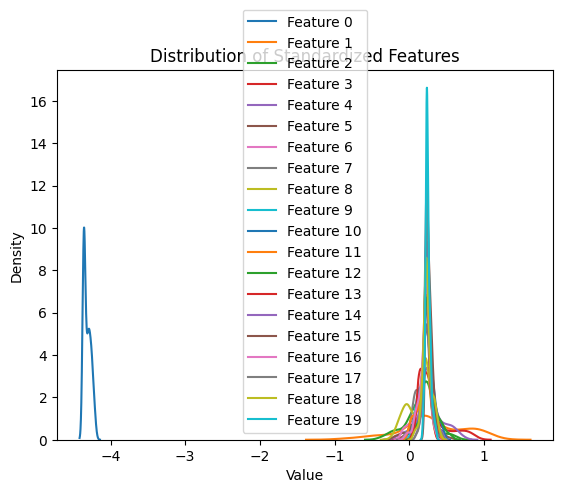

In [104]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
std_scaler = StandardScaler()
mfcc_std_scaled = std_scaler.fit_transform(mfcc)
print(mfcc_std_scaled)
# 如果 mfcc_std_scaled 是 NumPy 数组
print(mfcc_std_scaled.shape)
# 假设 mfcc_std_scaled 是形状为 (20, 108) 的 NumPy 数组
mfcc_std_scaled_df = pd.DataFrame(mfcc_std_scaled.T)
mfcc_std_scaled_df.head()
# 绘制所有特征的核密度图
for column in mfcc_std_scaled_df.columns:
    sns.kdeplot(data=mfcc_std_scaled_df[column], label=f'Feature {column}')
plt.legend()
plt.title('Distribution of Standardized Features')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

/tmp/ipykernel_27/2102865536.py:9: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=mfcc_std_scaled_df[column], label=f'Feature {column}')


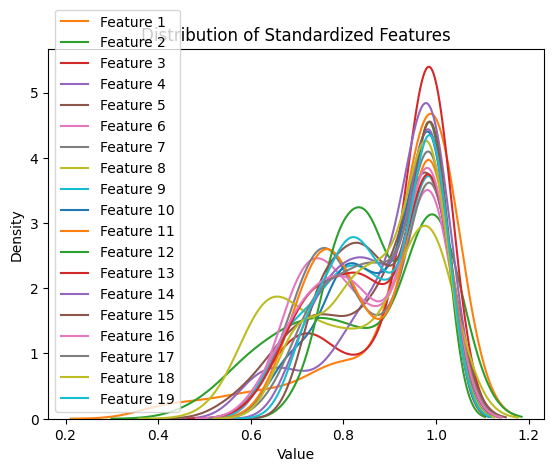

In [105]:
std_scaler = MinMaxScaler(feature_range=(-1, 1))
mfcc_std_scaled = std_scaler.fit_transform(mfcc)

mfcc_std_scaled_df = pd.DataFrame(mfcc_std_scaled.T)
mfcc_std_scaled_df.head()

for column in mfcc_std_scaled_df.columns:
    sns.kdeplot(data=mfcc_std_scaled_df[column], label=f'Feature {column}')
plt.legend()
plt.title('Distribution of Standardized Features')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

[[-1.1347826  -1.1347826  -1.1347826  ... -0.9759074  -0.98867005
  -0.9967823 ]
 [-0.91740733 -0.91740733 -0.91740733 ... -0.4477259  -0.47463292
  -0.47803134]
 [ 0.0538639   0.0538639   0.0538639  ...  1.1776338   1.1949033
   1.3526676 ]
 ...
 [ 0.49361914  0.49361914  0.49361914 ...  0.5320695   0.33047876
   0.5748902 ]
 [ 0.30042243  0.30042243  0.30042243 ...  0.17922702  0.11194841
   0.38148686]
 [ 0.39196727  0.39196727  0.39196727 ... -0.03499712 -0.09179847
   0.4836456 ]]


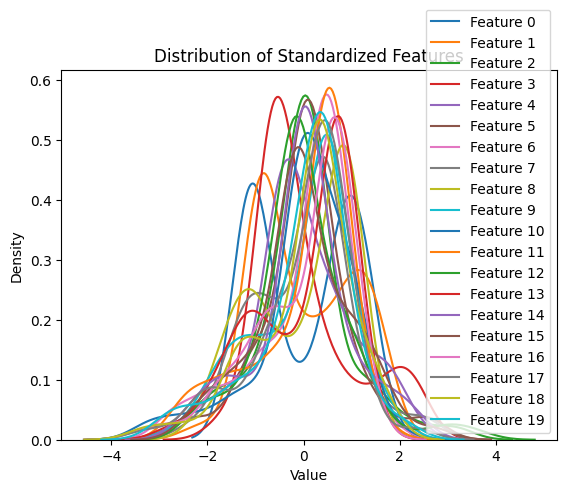

In [66]:
l_mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / (np.std(mfcc, axis=1, keepdims=True) + 1e-8)
print(l_mfcc)
mfcc_std_scaled_df = pd.DataFrame(l_mfcc.T)
mfcc_std_scaled_df.head()
# 绘制所有特征的核密度图
for column in mfcc_std_scaled_df.columns:
    sns.kdeplot(data=mfcc_std_scaled_df[column], label=f'Feature {column}')
plt.legend()
plt.title('Distribution of Standardized Features')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## Pre-Processing Dataset

### Define Augment Function

In [134]:
import numpy as np

def clip_audio(audio, duration, sr=22050, start_sec=0):
    start_sample = int(start_sec * sr)
    end_sample = start_sample + int(duration * sr)

    total_samples = len(audio)

    if start_sample < total_samples:
        clipped = audio[start_sample:min(end_sample, total_samples)]
    else:
        clipped = np.array([])

    current_length = len(clipped)
    required_length = int(duration * sr)

    if current_length < required_length:
        padding_length = required_length - current_length
        padding = np.zeros(padding_length, dtype=audio.dtype)
        clipped_audio = np.concatenate((clipped, padding))
    else:
        clipped_audio = clipped

    return clipped_audio

In [135]:
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    augmented_audio = augmented_audio.astype(type(audio[0]))
    return augmented_audio

In [136]:
def shift_pitch(audio, sr, n_steps):
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=n_steps)

In [137]:
def compute_and_save_mfcc(
    df, mfcc_dir, target_length=100, n_mfcc=20, sr=22050, n_fft=2048, hop_length=512, augmentations=None, pre_emphasis_coeff = 0.97
):
    os.makedirs(mfcc_dir, exist_ok=True)

    records = []

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        audio_path = row['path']
        label = row['label']
        filename = os.path.splitext(os.path.basename(audio_path))[0]

        try:
            audio, _ = librosa.load(audio_path, sr=sr, duration=2.5)
            audio = np.append(audio[0], audio[1:] - pre_emphasis_coeff * audio[:-1])
        except Exception as e:
            print(f"Error loading {audio_path}: {e}")
            continue

        for aug_name, aug_func in augmentations:
            if callable(aug_func):
                try:
                    aug_audio = aug_func(audio)
                except Exception as e:
                    print(f"Error applying {aug_name} on {audio_path}: {e}")
                    continue
            else:
                aug_audio = aug_func

            mfcc_filename = f"{filename}_{aug_name}.npy"
            mfcc_path = os.path.join(mfcc_dir, mfcc_filename)


            mfcc = librosa.feature.mfcc(y=aug_audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)


            std_scaler = StandardScaler()
            mfcc = std_scaler.fit_transform(mfcc)

            current_length = mfcc.shape[1]
            if current_length > target_length:
                mfcc = mfcc[:, :target_length]
            elif current_length < target_length:
                padding = np.zeros((mfcc.shape[0], target_length - current_length))
                mfcc = np.hstack((mfcc, padding))

            np.save(mfcc_path, mfcc)

            record = {
                'path': audio_path,
                'label': label,
                'mfcc_path': mfcc_path,
                'augmentation': aug_name,
            }
            records.append(record)

    augmented_df = pd.DataFrame(records)
    return augmented_df


### augmented

In [143]:
crema_df = crema_df.rename(columns={'emotion': 'label'})
ravdess_df = ravdess_df.rename(columns={'emotion': 'label'})

augment_dataset_list = [
    ('dataset/precomputed/crema/augmented_with_mfcc.csv', crema_df),
    ('dataset/precomputed/ravdess/augmented_with_mfcc.csv', ravdess_df)
]


In [144]:
select_index = 1
select = augment_dataset_list[select_index]
df_path = select[0]
orignal_df = select[1]
mfcc_directory = pathlib.Path(df_path).parent

try:
    select_df = pd.read_csv(df_path)
except FileNotFoundError:
    select_df = pd.DataFrame()

In [146]:
augmented_df = compute_and_save_mfcc(
    orignal_df,
    mfcc_directory,
    augmentations=[('original', lambda x: x)],
    target_length=108
)
select_df.drop_duplicates(keep='last', inplace=True)
select_df = pd.concat([select_df,augmented_df],ignore_index=True)
select_df.to_csv(df_path, index=False)

100%|██████████| 1056/1056 [00:07<00:00, 134.43it/s]


In [147]:
augmented_df = compute_and_save_mfcc(
    orignal_df,
    mfcc_directory,
    augmentations=[
        ('noise_0.002', lambda x: add_noise(x, noise_factor=0.002)),
        ('noise_0.001', lambda x: add_noise(x, noise_factor=0.001))
    ],
    target_length=108
)
select_df.drop_duplicates(keep='last', inplace=True)
select_df = pd.concat([select_df,augmented_df],ignore_index=True)
select_df.to_csv(df_path, index=False)

100%|██████████| 1056/1056 [00:15<00:00, 66.96it/s]


In [148]:
augmented_df = compute_and_save_mfcc(
    orignal_df,
    mfcc_directory,
    augmentations=[
        ('pitch_shift_up_1',   lambda x: shift_pitch(x, sr=22050, n_steps= 1)),
        ('pitch_shift_up_2',   lambda x: shift_pitch(x, sr=22050, n_steps= 2)),
        ('pitch_shift_down_1', lambda x: shift_pitch(x, sr=22050, n_steps=-1)),
        ('pitch_shift_down_2', lambda x: shift_pitch(x, sr=22050, n_steps=-2)),
    ],
    target_length=108
)
select_df.drop_duplicates(keep='last', inplace=True)
select_df = pd.concat([select_df,augmented_df],ignore_index=True)
select_df.to_csv(df_path, index=False)

100%|██████████| 1056/1056 [01:40<00:00, 10.55it/s]


In [176]:
print('總增強種類', set(select_df['augmentation']))
print('總筆數', len(select_df))
select_df.head()

總增強種類 {'noise_0.002', 'pitch_shift_down_1', 'original', 'pitch_shift_down_2', 'noise_0.001', 'pitch_shift_up_1', 'pitch_shift_up_2'}
總筆數 7392


,path,label,mfcc_path,augmentation,hash,is_train
0,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,neutral,dataset/precomputed/ravdess/03-01-01-01-01-01-...,original,204916812739800204955879346743213225432,True
1,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,neutral,dataset/precomputed/ravdess/03-01-01-01-01-02-...,original,315557857140665309549507933617641199263,True
2,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,neutral,dataset/precomputed/ravdess/03-01-01-01-02-01-...,original,234754169987577651876829999677284328523,True
3,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,neutral,dataset/precomputed/ravdess/03-01-01-01-02-02-...,original,156770576806434857841883984472643294350,True
4,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,happy,dataset/precomputed/ravdess/03-01-03-01-01-01-...,original,337230236396801791758203364281281539588,False


# Training Model

## Prepare Tran Test Dataset

In [149]:
dataset_list = [
    ['dataset/precomputed/crema/augmented_with_mfcc.csv', 'CREAM-D'],
    ['dataset/precomputed/ravdess/augmented_with_mfcc.csv', 'RAVDESS'],
]
select_index = 1
dataset_name = dataset_list[select_index][1]
select = dataset_list[select_index][0]
df_path = select

try:
    select_df = pd.read_csv(df_path)
except FileNotFoundError:
    select_df = pd.DataFrame()
print('總增強種類', set(select_df['augmentation']))
print('總筆數', len(select_df))
select_df.head()

總增強種類 {'noise_0.002', 'pitch_shift_down_1', 'original', 'pitch_shift_down_2', 'noise_0.001', 'pitch_shift_up_1', 'pitch_shift_up_2'}
總筆數 7392


,path,label,mfcc_path,augmentation
0,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,neutral,dataset/precomputed/ravdess/03-01-01-01-01-01-...,original
1,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,neutral,dataset/precomputed/ravdess/03-01-01-01-01-02-...,original
2,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,neutral,dataset/precomputed/ravdess/03-01-01-01-02-01-...,original
3,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,neutral,dataset/precomputed/ravdess/03-01-01-01-02-02-...,original
4,/root/.cache/kagglehub/datasets/uwrfkaggler/ra...,happy,dataset/precomputed/ravdess/03-01-03-01-01-01-...,original


In [3]:
import pandas as pd
import hashlib

def split_dataset(df, train_ratio=0.8):

    def hash_filename(path):
        filename = os.path.basename(path)
        return int(hashlib.md5(filename.encode()).hexdigest(), 16)
    
    df['hash'] = df['mfcc_path'].apply(hash_filename)
    

    df['is_train'] = df['hash'] % 100 < train_ratio * 100

    train_df = df[df['is_train']].reset_index(drop=True)
    val_df = df[~df['is_train']].reset_index(drop=True)

    train_df = train_df.drop(['hash', 'is_train'], axis=1)
    val_df = val_df.drop(['hash', 'is_train'], axis=1)
    
    return train_df, val_df

In [150]:
# 分割資料集
train_df, val_df = split_dataset(select_df, train_ratio=0.8)

print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")

Training set size: (5973, 4)
Validation set size: (1419, 4)


## Set DatasetLoader & Model

In [70]:
class AudioDataset(Dataset):
    def __init__(self, df, target_length=512,scaler=None, normalize=True):
        """
        Initialize the dataset with a DataFrame containing 'mfcc_path' and 'emotion' columns.

        Args:
            df (pd.DataFrame): DataFrame with 'mfcc_path' and 'emotion' columns.
            target_length (int): Number of time steps for MFCC features.
        """
        self.df = df
        self.target_length = target_length
        self.label_to_index = {
            'happy': 0,
            'neutral': 1,
            'sad': 2,
            'angry': 3,
            'fear': 4,
            'disgust': 5,
        }

    def __len__(self):
        return len(self.df)

    def _fit_scaler(self):
        all_mfcc = []
        for idx in range(len(self.df)):
            mfcc_path = self.df.iloc[idx]['mfcc_path']
            try:
                mfcc = np.load(mfcc_path)
                mfcc = self._pad_or_truncate(mfcc)
                all_mfcc.append(mfcc.flatten())
            except Exception as e:
                print(f"Error loading MFCC file {mfcc_path}: {e}")
                all_mfcc.append(np.zeros((20, self.target_length)).flatten())
        all_mfcc = np.array(all_mfcc)
        self.scaler.fit(all_mfcc)

    def __getitem__(self, idx):
        mfcc_path = self.df.iloc[idx]['mfcc_path']
        emotion = self.df.iloc[idx]['label']

        label = self.label_to_index[emotion]
        try:
            mfcc = np.load(mfcc_path)
        except Exception as e:
            print(f"Error loading MFCC file {mfcc_path}: {e}")
            mfcc = np.zeros((20, self.target_length))
        mfcc_tensor = torch.FloatTensor(mfcc)
        label_tensor = torch.LongTensor([label])

        return mfcc_tensor, label_tensor

    @staticmethod
    def index_to_label(index):
        label_to_index = {
            'happy': 0,
            'neutral': 1,
            'sad': 2,
            'angry': 3,
            'fear': 4,
            'disgust': 5,
        }
        index_to_label = {v: k for k, v in label_to_index.items()}
        if index in index_to_label:
            return index_to_label[index]
        else:
            raise ValueError(f"Index {index} is not a valid label index.")

In [6]:
class SER(nn.Module):
    def __init__(self):
        super(SER, self).__init__()

        cnn_args = [
            [20, 512, 5, 1, 2],
            [512, 512, 5, 1, 2],
            [512, 256, 5, 1, 2],
            [256, 256, 3, 1, 1],
            [256, 128, 3, 1, 1],
        ]
        pool_args = [
            [5, 2, 2],
            [5, 2, 2],
            [5, 2, 2],
            [3, 2, 1],
            [3, 2, 1],
        ]
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)  # 輸出時間維度為 1
        norm_args = [512, 512, 256, 256, 128]

        self.cnn_layers = nn.ModuleList()

        for cnn_arg, pool_arg, norm_arg in zip(cnn_args, pool_args, norm_args):
            self.cnn_layers.append(
                nn.Sequential(
                    nn.Conv1d(
                        in_channels=cnn_arg[0], out_channels=cnn_arg[1],
                        kernel_size=cnn_arg[2], stride=cnn_arg[3], padding=cnn_arg[4]
                    ),
                    nn.ReLU(),                                                                     
                    nn.BatchNorm1d(norm_arg),                                                           
                    nn.MaxPool1d(
                        kernel_size=pool_arg[0], stride=pool_arg[1], padding=pool_arg[2]
                    )                              
                )
            )
        self.fc_layers = nn.Sequential(
            nn.Linear(128*4, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 6)
        )

    def forward(self, x):
        for cnn_layer in self.cnn_layers:
            x = cnn_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

## Traiing Model

In [171]:
batch_size = 1024

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if int(len(train_df) % 2) == 1:
    train_df = train_df[:-(len(train_df) % 2)]
    
if int(len(val_df) % 2) == 1:
    val_df = val_df[:-(len(val_df) % 2)]
    
print('Size of Train Dataset ', len(train_df))
print('Size of Val Dataset',    len(val_df))

train_dataset = AudioDataset(train_df, target_length=108)
val_dataset = AudioDataset(val_df, target_length=108)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

Size of Train Dataset  5972
Size of Val Dataset 1418


In [172]:
model = SER().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1s = []
val_f1s = []


scaler =  torch.amp.GradScaler()
best_val_acc = 0.0
best_epoch = 0
num_epochs = 50
report_label = f'epochs-{num_epochs}_batchSize-{batch_size}'

result_report_dir = os.path.join('report', dataset_name)

reports_path = {
    'classification':   os.path.join(result_report_dir, report_label, 'classification_report'),
    'confusion_matrix': os.path.join(result_report_dir, report_label, 'confusion_matrix'),
    'train_log':        os.path.join(result_report_dir, report_label, 'train_log'),
    'model_wieghts':    os.path.join(result_report_dir, report_label, 'weights'),
    'root':             os.path.join(result_report_dir, report_label),
}

for r_path in reports_path.values():
    print(r_path)
    os.makedirs(r_path, exist_ok=True)

report/RAVDESS/epochs-50_batchSize-1024/classification_report
report/RAVDESS/epochs-50_batchSize-1024/confusion_matrix
report/RAVDESS/epochs-50_batchSize-1024/train_log
report/RAVDESS/epochs-50_batchSize-1024/weights
report/RAVDESS/epochs-50_batchSize-1024


In [173]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.squeeze().to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    
    # Val
    model.eval()
    train_preds = []
    train_labels = []
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze().to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    train_accuracies.append(train_acc)
    train_f1s.append(train_f1)

    val_preds = []
    val_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.squeeze().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_loss = val_loss / len(val_dataset)
    val_losses.append(val_loss)
    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)


    
    cm = confusion_matrix(val_labels, val_preds)
    report = classification_report(val_labels, val_preds, output_dict=True, zero_division=0)
    
    metrics_data = []
    for label in range(len(report) - 3):
        metrics_data.append({
            'category': AudioDataset.index_to_label(label),
            'precision': report[str(label)]['precision'],
            'recall': report[str(label)]['recall'],
            'f1': report[str(label)]['f1-score']
        })
    
    avg_accuracy = accuracy_score(val_labels, val_preds)
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df['average_accuracy'] = avg_accuracy
    
    metrics_df.to_csv(os.path.join(reports_path['classification'], f'metrics_epoch_{epoch+1}.csv'), index=False)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}')
    if val_acc > best_val_acc:
        best_epoch = epoch
        best_val_acc = val_acc
        torch.save(model.state_dict(), os.path.join(reports_path['model_wieghts'], f'{epoch+1}_SER_model.pth'))
    cm_df = pd.DataFrame(cm)
    cm_df.to_csv(os.path.join(reports_path['confusion_matrix'], f'cm_epoch_{epoch+1}.csv'), index=False)
    with open(os.path.join(reports_path['train_log'], f'report_epoch_{epoch+1}.txt'), 'w') as f:
        f.write(classification_report(val_labels, val_preds, zero_division=0))
        
print('訓練完成。最佳驗證準確率: {:.4f}'.format(best_val_acc))
        

# 建立 DataFrame
history_df = pd.DataFrame({
    'epoch': range(1, num_epochs + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_accuracy': train_accuracies,
    'val_accuracy': val_accuracies,
    'train_f1': train_f1s,
    'val_f1': val_f1s
})

# 儲存到 CSV
history_df.to_csv(os.path.join(reports_path['root'], 'training_history.csv'), index=False)
print("訓練歷史數據已儲存到 training_history.csv")

Epoch 1/50, Loss: 1.5003, Train Acc: 0.2338, Train F1: 0.1203, Val Acc: 0.2257, Val F1: 0.1109
Epoch 2/50, Loss: 0.9306, Train Acc: 0.1936, Train F1: 0.0851, Val Acc: 0.1819, Val F1: 0.0721
Epoch 3/50, Loss: 0.5995, Train Acc: 0.2040, Train F1: 0.0944, Val Acc: 0.1953, Val F1: 0.0881
Epoch 4/50, Loss: 0.3578, Train Acc: 0.2701, Train F1: 0.1542, Val Acc: 0.2814, Val F1: 0.1661
Epoch 5/50, Loss: 0.1922, Train Acc: 0.3173, Train F1: 0.2310, Val Acc: 0.3138, Val F1: 0.2394
Epoch 6/50, Loss: 0.1131, Train Acc: 0.5095, Train F1: 0.4640, Val Acc: 0.5028, Val F1: 0.4629
Epoch 7/50, Loss: 0.1047, Train Acc: 0.6433, Train F1: 0.6491, Val Acc: 0.6276, Val F1: 0.6297
Epoch 8/50, Loss: 0.0737, Train Acc: 0.7115, Train F1: 0.7144, Val Acc: 0.6953, Val F1: 0.6960
Epoch 9/50, Loss: 0.0374, Train Acc: 0.8786, Train F1: 0.8776, Val Acc: 0.8449, Val F1: 0.8434
Epoch 10/50, Loss: 0.0233, Train Acc: 0.9437, Train F1: 0.9442, Val Acc: 0.8886, Val F1: 0.8902
Epoch 11/50, Loss: 0.0137, Train Acc: 0.9801, Tra

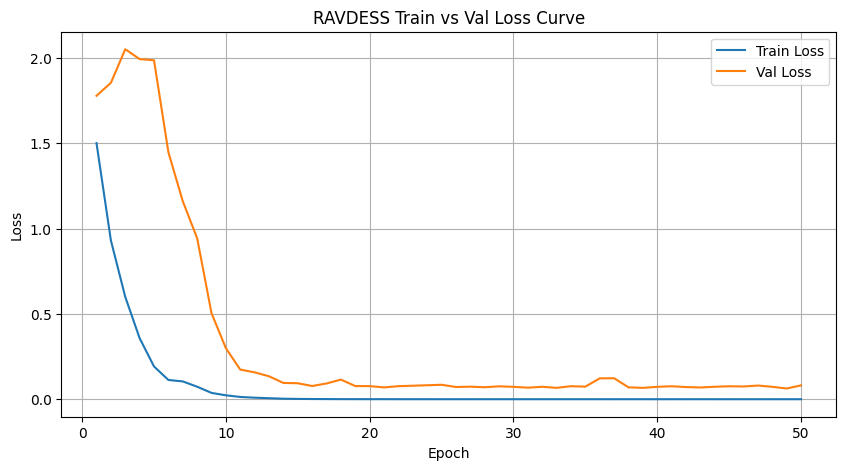

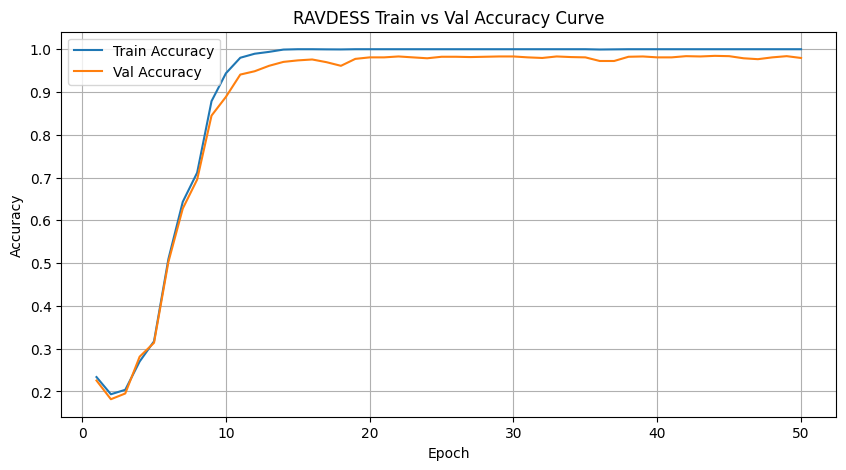

In [174]:
import matplotlib.pyplot as plt
import pandas as pd

# 讀取 CSV 檔案
history_df = pd.read_csv(os.path.join(reports_path['root'], 'training_history.csv'))

# 繪製訓練和驗證損失曲線
plt.figure(figsize=(10, 5))
plt.plot(history_df['epoch'], history_df['train_loss'], label='Train Loss')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{dataset_name} Train vs Val Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(reports_path['root'], "train_vs_val_loss_curve.png"))
plt.show()

# 繪製訓練和驗證準確度曲線
plt.figure(figsize=(10, 5))
plt.plot(history_df['epoch'], history_df['train_accuracy'], label='Train Accuracy')
plt.plot(history_df['epoch'], history_df['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'{dataset_name} Train vs Val Accuracy Curve')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(reports_path['root'], "train_vs_val_accuracy_curve.png"))
plt.show()

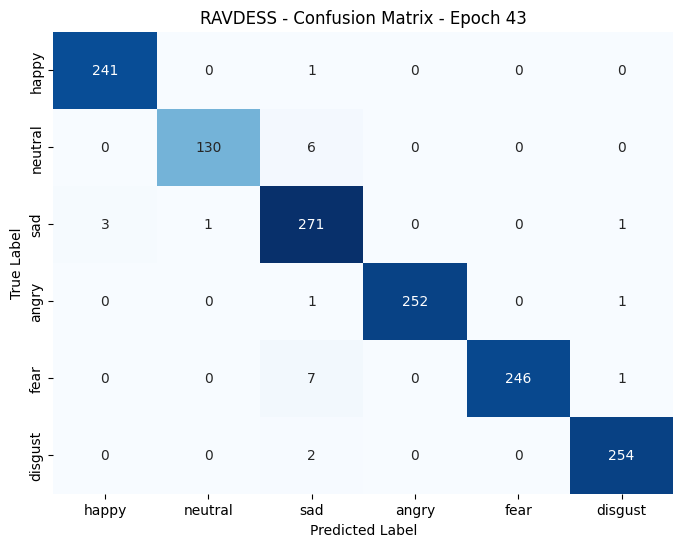

In [175]:
# 假設你想讀取第 5 個 epoch 的混淆矩陣
epoch_to_plot = best_epoch
cm_file = os.path.join(reports_path['confusion_matrix'], f'cm_epoch_{epoch_to_plot}.csv')

# 假設你的類別名稱
class_names = ['happy', 'neutral', 'sad', 'angry', 'fear', 'disgust'] # 請替換成你的實際類別名稱

# 讀取混淆矩陣 CSV 檔案
try:
    cm_df = pd.read_csv(cm_file) # 假設 CSV 沒有 header 和 index
    cm = cm_df.values  # 轉換成 numpy array

    # 繪製混淆矩陣
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names,  # 設定 X 軸標籤
                yticklabels=class_names)   # 設定 Y 軸標籤 (假設 True Label 和 Predicted Label 的名稱相同)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{dataset_name} - Confusion Matrix - Epoch {epoch_to_plot}')
    plt.savefig(os.path.join(reports_path['root'], f"confusion_matrix_epoch_{epoch_to_plot}.png"))
    plt.show()
except FileNotFoundError:
    print(f"找不到混淆矩陣檔案：{cm_file}")
except Exception as e:
    print(f"讀取或繪製混淆矩陣時發生錯誤：{e}")